In [1]:
library(tidyverse)

Warning message:
“Installed Rcpp (0.12.14) different from Rcpp used to build dplyr (0.12.13).
Please reinstall dplyr to avoid random crashes or undefined behavior.”Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
data_path <- '../data/'
df <- read_csv(paste0(data_path, 'predicted_Q_df_test.csv'))
action_df <- read_csv(paste0(data_path, 'action_df.csv'))

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer(),
  subject_id = col_integer(),
  hadm_id = col_integer(),
  icustay_id = col_integer(),
  interval_start_time = col_datetime(format = ""),
  interval_end_time = col_datetime(format = ""),
  discrete_action = col_integer(),
  hospital_expire_flag = col_integer(),
  reward = col_integer(),
  best_action = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  subject_id = col_integer(),
  hadm_id = col_integer(),
  icustay_id = col_integer(),
  interval_start_time = col_datetime(format = ""),
  interval_end_time = col_datetime(format = ""),
  total_IV = col_double(),
  discrete_IV = col_integer(),
  max_VP = col_double(),
  discrete_pressor = col_integer(),
  discrete_action = col_integer()
)


In [23]:
head(df)

X1,subject_id,hadm_id,icustay_id,interval_start_time,interval_end_time,ALBUMIN,ANION GAP,BANDS,BICARBONATE,⋯,elixhauser_hospital,blood_culture_positive,discrete_action,hospital_expire_flag,reward,row_id,row_id_next,predicted_Q_physician,predicted_Q_optimal,best_action
0,145,198161,226841,2144-03-29 19:00:00,2144-03-29 23:00:00,-0.05746277,0.02267872,-0.2986458,-0.5996432,⋯,1.463854,-0.6855025,4,0,0,0,1,15.28691,18.15419,7
1,145,198161,226841,2144-03-29 23:00:00,2144-03-30 03:00:00,0.08514148,-0.72206787,-0.2986458,-0.3857340,⋯,1.463854,-0.6855025,3,0,0,1,2,15.35639,16.96789,7
2,145,198161,226841,2144-03-30 03:00:00,2144-03-30 07:00:00,0.08514148,-0.72206787,-0.2986458,-0.3857340,⋯,1.463854,-0.6855025,3,0,0,2,3,15.08211,16.68488,7
3,145,198161,226841,2144-03-30 07:00:00,2144-03-30 11:00:00,0.08514148,-0.72206787,-0.2986458,-0.3857340,⋯,1.463854,-0.6855025,2,0,0,3,4,14.64352,16.76873,7
4,145,198161,226841,2144-03-30 11:00:00,2144-03-30 15:00:00,0.08514148,-0.72206787,-0.2986458,-0.3857340,⋯,1.463854,-0.6855025,0,0,0,4,5,14.81234,16.38659,7
5,145,198161,226841,2144-03-30 15:00:00,2144-03-30 19:00:00,0.08514148,-0.72206787,-0.2986458,-1.6691893,⋯,1.463854,-0.6855025,0,0,0,5,6,12.42933,15.79496,16


In [24]:
# action_mappings <- action_df %>% select(discrete_IV, discrete_pressor, discrete_action) %>% distinct()

In [25]:
library(caret)
action_mappings <- expand.grid(discrete_IV = c(0, 1, 2, 3, 4), discrete_pressor = c(0, 1,2, 3, 4)) %>% mutate(discrete_action = 0:24)

In [26]:
temp <- df %>% full_join(action_mappings) %>% 
#                 replace_na(list(action_count = 0)) +
                group_by(discrete_IV, 
                         discrete_pressor, 
                         discrete_action) %>% 
                summarise(action_count = n())

Joining, by = "discrete_action"


In [27]:
print(temp %>% arrange(desc(action_count)))

# A tibble: 25 x 4
# Groups:   discrete_IV, discrete_pressor [25]
   discrete_IV discrete_pressor discrete_action action_count
         <dbl>            <dbl>           <int>        <int>
 1           0                0               0         4877
 2           2                0               2         3477
 3           3                0               3         3422
 4           1                0               1         3304
 5           4                0               4         2995
 6           4                4              24          204
 7           4                2              14          194
 8           4                3              19          183
 9           4                1               9          164
10           1                1               6          112
# ... with 15 more rows


In [28]:
sapply(temp, function(x) sum(is.na(x)))

discrete_IV discrete_pressor  discrete_action     action_count 
               0                0                0                0

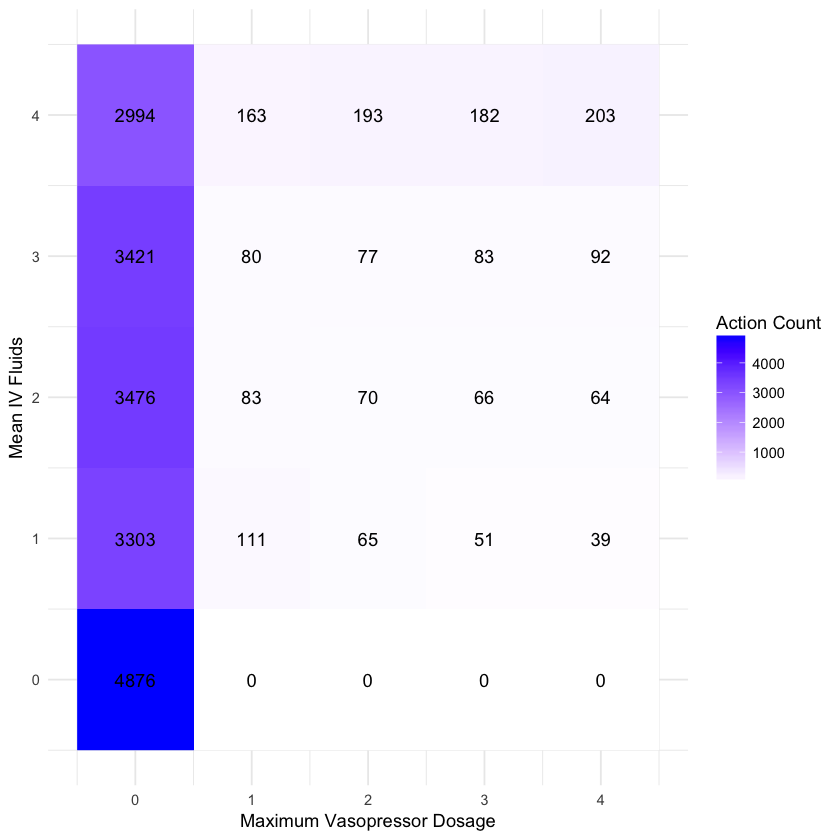

In [29]:
ggplot(temp, aes(discrete_pressor, discrete_IV)) + 
                geom_raster(aes(fill = action_count)) + 
                geom_text(aes(label = round(action_count - 1, 3))) + 
                theme_minimal() +
                scale_fill_gradient(low = "white", high = "blue", name = 'Action Count'
#                                     , 
#                                     limits = c(0, 5000)
                                   ) + 
                xlab('Maximum Vasopressor Dosage') + 
                ylab('Mean IV Fluids')

In [30]:
ggsave('../figures/physician_policy_matrix.png', width = 6, height = 6, units = 'in')

In [31]:
temp <- df %>% select(-discrete_action) %>% 
                full_join(action_mappings, c("best_action" = "discrete_action")) %>% 
                group_by(discrete_IV, 
                         discrete_pressor, 
                         best_action) %>% 
                summarise(action_count = n()) %>% 
                arrange(desc(action_count))

In [32]:
temp

discrete_IV,discrete_pressor,best_action,action_count
3,3,18,2196
2,1,7,1572
3,4,23,1536
3,2,13,1425
0,0,0,1370
4,1,9,1252
2,2,12,1153
2,3,17,1080
1,3,16,975
4,4,24,899


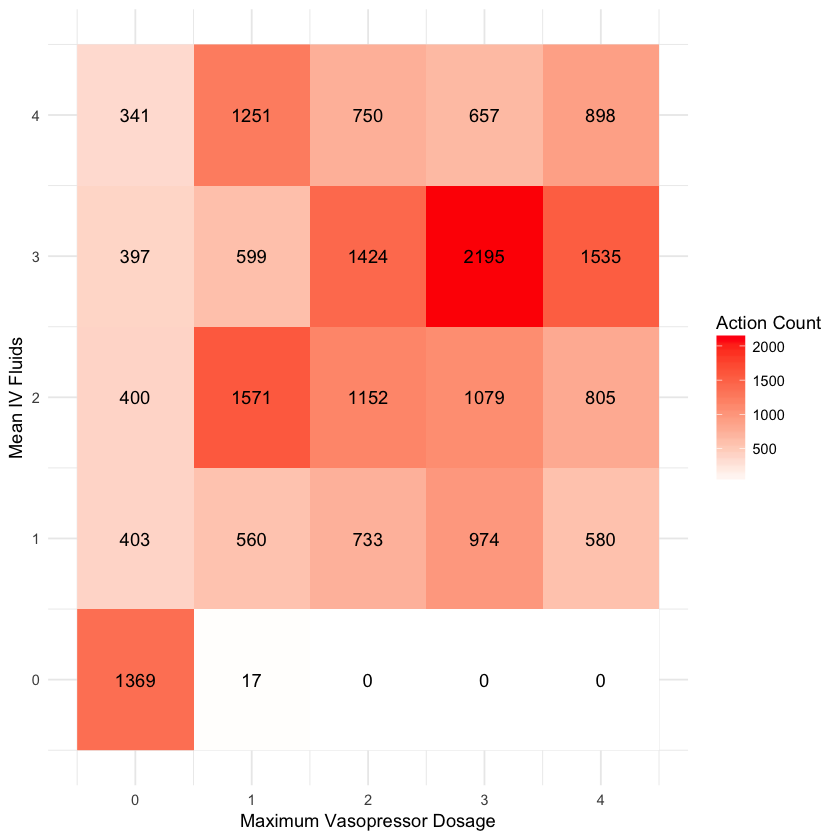

In [33]:
ggplot(temp, aes(discrete_pressor, discrete_IV)) + 
                geom_raster(aes(fill = action_count)) + 
                geom_text(aes(label = round(action_count - 1, 3))) + 
                theme_minimal() +
                scale_fill_gradient(low = "white", high = "red", name = 'Action Count') + 
                xlab('Maximum Vasopressor Dosage') + 
                ylab('Mean IV Fluids')

In [34]:
ggsave('../figures/optimal_policy_matrix.png', width = 6, height = 6, units = 'in')